<a href="https://colab.research.google.com/github/rafinha-es/PFC_Game_Data_Science/blob/main/LOL_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANDO DADOS DO DRIVE E BIBLIOTECAS (Compilar por primeiro)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import requests
import pandas as pd
import csv
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


COLETA DE DADOS VIA API - NÃO COMPILAR NOVAMENTE!

In [ ]:

# Substitua por sua própria chave da API
API_KEY = 'RGAPI-ec9a1949-8fe0-485f-841f-e160f2a9a185'
REGION = 'br1'  # Região para o Brasil (pode ser 'na1' para Norte-América, etc.)

def get_summoner_id(gameName, tagLine):
    url = f'https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{gameName}/{tagLine}'
    headers = {'X-Riot-Token': API_KEY}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()['puuid']
    else:
        print(f'Error fetching summoner ID: {response.status_code}')
        return None

def get_matchlist(puuid):
    url = f'https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids'
    headers = {'X-Riot-Token': API_KEY}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f'Error fetching match list: {response.status_code}')
        return None

def get_match_data(match_id):
    url = f'https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}'
    headers = {'X-Riot-Token': API_KEY}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f'Error fetching match data: {response.status_code}')
        return None

def get_match_timeline(match_id):
    url = f'https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline'
    headers = {'X-Riot-Token': API_KEY}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f'Error fetching match timeline: {response.status_code}')
        return None

def create_dataframe(match_data_list, match_timeline_list):
    rows = []

    for match_data, match_timeline in zip(match_data_list, match_timeline_list):
        #print('Processing match:', match_data['info']['gameId'])

        first_kill_time = float('inf')  # Inicializa com um valor muito alto
        first_kill_team = None  # Ainda não sabemos quem fez a primeira kill

        # Check if 'frames' key exists in match_timeline['info']
        if 'frames' in match_timeline['info']:
            for frame in match_timeline['info']['frames']:
                for event in frame.get('events', []):
                    if event['type'] == 'CHAMPION_KILL':  # Evento de kill encontrado
                        killer_id = event.get('killerId', 0)
                        victim_id = event.get('victimId', 0)

                        # Verifica se tanto o assassino quanto a vítima são jogadores válidos
                        if killer_id != 0 and victim_id != 0:
                            event_time = event['timestamp']

                            # Se for a primeira kill feita por um player contra outro player
                            if event_time < first_kill_time:
                                first_kill_time = event_time

                                # Descobre qual time fez a first kill
                                for participant in match_data['info']['participants']:
                                    if participant['participantId'] == killer_id:
                                        first_kill_team = participant['teamId']  # Guarda o time numérico (100 ou 200)
                                        #print(f"A first kill foi feita pelo time {'Blue' if first_kill_team == 100 else 'Red'}")
                                        break  # Já encontramos, podemos parar a busca
        else:
            print("No 'frames' key found in match_timeline['info']")

        for participant in match_data['info']['participants']:
            team_color = 'Blue' if participant['teamId'] == 100 else 'Red'
            row = {
                'Game ID': match_data['info']['gameId'],
                'Duration': match_data['info']['gameDuration'],
                'Game Mode': match_data['info']['gameMode'],
                'Summoner Name': participant['summonerName'],
                'Champion': participant['championName'],
                'Kills': participant['kills'],
                'Deaths': participant['deaths'],
                'Assists': participant['assists'],
                'Team ID': participant['teamId'],
                'Team': team_color,
                'Team FK': first_kill_team is not None and first_kill_team == participant['teamId'],
                'Team Win': "Win" if participant['win'] == True else "Lose",
            }
            rows.append(row)

    df = pd.DataFrame(rows)
    return df

def main():
    full_tag = "dyNNKaz #1010" #Riot ID do player

    gameName, tagLine = full_tag.split(" #")
    summoner_puuid = get_summoner_id(gameName, tagLine)

    if not summoner_puuid:
        return

    match_ids = get_matchlist(summoner_puuid)

    if not match_ids:
        return

    match_data_list = []
    match_timeline_list = []

    # Obtemos os dados de até 20 partidas para demonstração
    for match_id in match_ids[:20]:
        match_data = get_match_data(match_id)
        match_timeline = get_match_timeline(match_id)

        if match_data and match_timeline:
            match_data_list.append(match_data)
            match_timeline_list.append(match_timeline)

    # Criar o DataFrame
    df = create_dataframe(match_data_list, match_timeline_list)

    # Salvar o DataFrame em um arquivo CSV
    df.to_csv(f'/content/gameplay_data_players/gameplay_data_{gameName}{tagLine}.csv', index=False)
    print(f'Dados salvos em gameplay_data_{gameName}{tagLine}.csv')

if __name__ == '__main__':
    main()

TESTE DA BASE POR JOGADOR

In [ ]:
file_path = '/content/drive/MyDrive/Databases/root/gameplay_data_tinownsBR2.csv'
df = pd.read_csv(file_path)
df.head(20)

TESTE DAS BASES DE DADOS UNIFICADAS

In [ ]:
with open("/content/drive/MyDrive/Databases/updated_ALL_gameplay_data.csv", "r", encoding="utf-8") as f:
    reader = csv.reader(f)
    num_linhas = sum(1 for _ in reader) - 1  # Subtrai 1 para ignorar o cabeçalho
print(f"O arquivo tem {num_linhas} linhas de dados.")

In [ ]:
# Define the directory containing the CSV files
csv_directory = '/content/gameplay_data_players'

# Define the output file name
output_file = 'ALL_gameplay_data.csv'

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through all files in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(csv_directory, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Append the DataFrame to the list
        dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
unified_df = pd.concat(dataframes, ignore_index=True)

# Write the unified DataFrame to a new CSV file (header is written only once)
unified_df.to_csv(output_file, index=False)

print(f"All CSV files have been unified into {output_file}")

All CSV files have been unified into ALL_gameplay_data.csv


In [ ]:
df = pd.read_csv('/content/ALL_gameplay_data.csv')

# Calculate KD with division by zero handling
df['KD'] = np.where(df['Deaths'] == 0, df['Kills'], df['Kills'] / df['Deaths'])

# Calculate KDA with division by zero handling
df['KDA'] = np.where(df['Deaths'] == 0, (df['Kills'] + df['Assists']), (df['Kills'] + df['Assists']) / df['Deaths'])

# Calculate DF with division by zero handling
df['DF'] = (3*(df['Kills']) + 1*(df['Assists']) - (3*df['Deaths']))

# Calculate KDA with division by zero handling
df['DR'] = np.where(df['Deaths'] == 0, (2*(df['Kills']) + 1*(df['Assists'])), (2*(df['Kills']) + 1*(df['Assists']))/(3*df['Deaths']))


#print("Original DataFrame:")
print(df)
output_path = '/content/updated_ALL_gameplay_data.csv'
df.to_csv(output_path, index=False)

print(f"Updated DataFrame saved to {output_path}")

        Game ID  Duration Game Mode    Summoner Name Champion  Kills  Deaths  \
0    3062115924      1271   CLASSIC   daron reformed    Jayce      1       6   
1    3062115924      1271   CLASSIC  Kizuna Kazayama     Kayn      8       6   
2    3062115924      1271   CLASSIC             Löus      Mel      2       4   
3    3062115924      1271   CLASSIC          Vipeeer   Draven      1       5   
4    3062115924      1271   CLASSIC             VouX    Elise      4       6   
..          ...       ...       ...              ...      ...    ...     ...   
795  3058738966      1031   CLASSIC   Arthur Lanches    Teemo      1       2   
796  3058738966      1031   CLASSIC           Canyon       Vi      3       3   
797  3058738966      1031   CLASSIC  NeverBrokëAgain    Sylas      6       0   
798  3058738966      1031   CLASSIC            TitaN    Kaisa     10       4   
799  3058738966      1031   CLASSIC          Vahvel1     Rell      2       5   

     Assists  Team ID  Team  Team FK Te

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Databases/updated_ALL_gameplay_data.csv')
df.drop(columns=["Game ID", "Team ID"]).describe()

,Duration,Kills,Deaths,Assists,KD,KDA,DF,DR
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,1597.987500,5.675000,5.698750,9.162500,1.445999,3.672318,9.091250,2.038606
std,354.681175,4.405239,3.150858,7.146673,1.761939,3.685982,16.368807,3.133345
min,149.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-29.000000,0.000000
25%,1390.250000,2.000000,4.000000,4.000000,0.400000,1.428571,-3.000000,0.666667
50%,1631.000000,5.000000,5.000000,7.500000,0.875000,2.514706,8.000000,1.166667
75%,1822.750000,8.000000,8.000000,12.000000,1.861607,4.250000,20.000000,2.055556
max,2328.000000,28.000000,18.000000,54.000000,13.000000,32.000000,68.000000,31.000000


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Databases/updated_ALL_gameplay_data.csv')
df_byTeam = df.groupby(["Game ID", "Team"]).agg({ #As colunas a serem filtradas vão como argumentos no df.groupby
    "Duration": "first",
    "Kills": "mean",       # Somar kills do time
    "Deaths": "mean",
    "Assists": "mean",
    "Team FK": "first",   # Manter primeiro valor (é igual para o time todo)
    "Team Win": "first"   # Manter primeiro valor (é igual para o time todo)
}).reset_index()

# Exibir resultado
print(df_byTeam)
df_byTeam.describe()

        Game ID  Team  Duration  Kills  Deaths  Assists  Team FK Team Win
0    3054519767  Blue      1471    7.2     3.4     16.0     True      Win
1    3054519767   Red      1471    3.4     7.2      6.0    False     Lose
2    3054536178  Blue      2020    4.8     5.0      9.0     True     Lose
3    3054536178   Red      2020    5.0     4.8     10.2    False      Win
4    3054555536  Blue      1581    5.4     7.6      7.0    False     Lose
..          ...   ...       ...    ...     ...      ...      ...      ...
155  3062179931   Red      1450   15.0    13.8     30.8     True      Win
156  3062195980  Blue      1354   11.6    12.6     22.8    False     Lose
157  3062195980   Red      1354   12.6    11.6     30.0     True      Win
158  3062210450  Blue      1148   10.4     9.0     30.0    False      Win
159  3062210450   Red      1148    9.0    10.4     22.4     True     Lose

[160 rows x 8 columns]


,Game ID,Duration,Kills,Deaths,Assists
count,1.600000e+02,160.000000,160.000000,160.000000,160.00000
mean,3.059786e+09,1597.987500,5.675000,5.698750,9.16250
std,2.138241e+06,355.572335,2.451107,2.452363,5.54865
min,3.054520e+09,149.000000,0.000000,0.000000,0.00000
25%,3.058835e+09,1390.250000,4.200000,4.200000,5.55000
50%,3.060334e+09,1631.000000,5.600000,5.600000,8.30000
75%,3.061200e+09,1822.750000,7.250000,7.250000,11.80000
max,3.062210e+09,2328.000000,15.000000,15.000000,30.80000


Célula para gravar .csv filtrado por time/partida

In [ ]:
output_path = '/content/drive/MyDrive/Databases/byTeam_gameplay_data.csv'
df_byTeam.to_csv(output_path, index=False)
print(f"Updated DataFrame saved to {output_path}")

Updated DataFrame saved to /content/drive/MyDrive/Databases/byTeam_gameplay_data.csv


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Databases/updated_ALL_gameplay_data.csv')
df_byMatch = df.groupby(["Game ID"]).agg({ #As colunas a serem filtradas vão como argumentos no df.groupby
    "Duration": "first",
    "Kills": "sum",       # Somar kills do time
    "Deaths": "sum",
    "Assists": "sum",

}).reset_index()

# Exibir resultado
print(df_byMatch)
df_byMatch.describe()

       Game ID  Duration  Kills  Deaths  Assists
0   3054519767      1471     53      53      110
1   3054536178      2020     49      49       96
2   3054555536      1581     65      65       85
3   3054574519      1933     61      61       97
4   3054962686      1535     39      39       53
..         ...       ...    ...     ...      ...
75  3062095327      1759     60      60      109
76  3062115924      1271     43      44       55
77  3062179931      1450    144     144      305
78  3062195980      1354    121     121      264
79  3062210450      1148     97      97      262

[80 rows x 5 columns]


,Game ID,Duration,Kills,Deaths,Assists
count,8.000000e+01,80.000000,80.000000,80.000000,80.000000
mean,3.059786e+09,1597.987500,56.750000,56.987500,91.625000
std,2.144997e+06,356.695789,20.401353,20.432968,49.785966
min,3.054520e+09,149.000000,1.000000,1.000000,1.000000
25%,3.058835e+09,1390.250000,45.250000,45.500000,58.750000
50%,3.060334e+09,1631.000000,56.000000,56.500000,85.000000
75%,3.061200e+09,1822.750000,66.250000,66.250000,109.000000
max,3.062210e+09,2328.000000,144.000000,144.000000,305.000000


Times vencedores

In [ ]:
# Filtrar apenas os times vencedores
df_winners = df_byTeam[df_byTeam["Team Win"] == "Win"]

# Exibir resultado
print(df_winners)
df_winners.describe()

Times perdedores

In [ ]:
# Filtrar apenas os times vencedores
df_losers = df_byTeam[df_byTeam["Team Win"] == "Lose"]

# Exibir resultado
print(df_losers)
df_losers.describe()

        Game ID  Team  Duration  Kills  Deaths  Assists  Team FK Team Win
1    3054519767   Red      1471     17      36       30    False     Lose
2    3054536178  Blue      2020     24      25       45     True     Lose
4    3054555536  Blue      1581     27      38       35    False     Lose
6    3054574519  Blue      1933     25      36       40    False     Lose
8    3054962686  Blue      1535      6      33       10    False     Lose
..          ...   ...       ...    ...     ...      ...      ...      ...
151  3062095327   Red      1759     22      38       27     True     Lose
152  3062115924  Blue      1271     16      27       15    False     Lose
154  3062179931  Blue      1450     69      75      151    False     Lose
156  3062195980  Blue      1354     58      63      114    False     Lose
159  3062210450   Red      1148     45      52      112     True     Lose

[80 rows x 8 columns]


,Game ID,Duration,Kills,Deaths,Assists
count,8.000000e+01,80.000000,80.000000,80.000000,80.000000
mean,3.059786e+09,1597.987500,22.562500,34.300000,35.725000
std,2.144997e+06,356.695789,11.294497,10.326812,25.012895
min,3.054520e+09,149.000000,0.000000,1.000000,0.000000
25%,3.058835e+09,1390.250000,15.000000,27.750000,19.750000
50%,3.060334e+09,1631.000000,22.500000,34.000000,33.500000
75%,3.061200e+09,1822.750000,28.000000,40.000000,45.000000
max,3.062210e+09,2328.000000,69.000000,75.000000,151.000000


VISUALIZAÇÃO COM GRÁFICOS

In [ ]:
df_players = pd.read_csv("/content/drive/MyDrive/Databases/updated_ALL_gameplay_data.csv")
df_teams = pd.read_csv("/content/drive/MyDrive/Databases/byTeam_gameplay_data.csv")

print(df_teams)

        Game ID  Team  Duration  Kills  Deaths  Assists  Team FK Team Win
0    3054519767  Blue      1471    7.2     3.4     16.0     True      Win
1    3054519767   Red      1471    3.4     7.2      6.0    False     Lose
2    3054536178  Blue      2020    4.8     5.0      9.0     True     Lose
3    3054536178   Red      2020    5.0     4.8     10.2    False      Win
4    3054555536  Blue      1581    5.4     7.6      7.0    False     Lose
..          ...   ...       ...    ...     ...      ...      ...      ...
155  3062179931   Red      1450   15.0    13.8     30.8     True      Win
156  3062195980  Blue      1354   11.6    12.6     22.8    False     Lose
157  3062195980   Red      1354   12.6    11.6     30.0     True      Win
158  3062210450  Blue      1148   10.4     9.0     30.0    False      Win
159  3062210450   Red      1148    9.0    10.4     22.4     True     Lose

[160 rows x 8 columns]


Team Win
Win     44
Lose    36
Name: count, dtype: int64


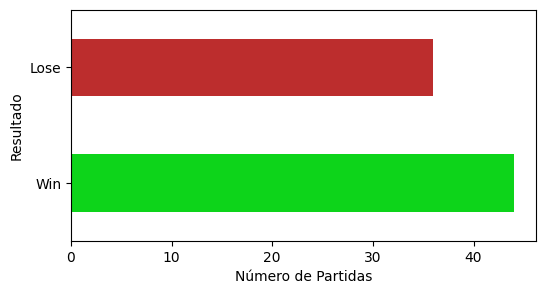

In [ ]:
# Carregar base já agregada por time
df_teams = pd.read_csv("/content/drive/MyDrive/Databases/byTeam_gameplay_data.csv")

# Pegar apenas o time que fez a First Kill (1 por partida)
fk_true = df_teams[df_teams["Team FK"] == 1]

# Verificar se o time que fez a First Kill venceu ou perdeu
fk_vs_win = fk_true["Team Win"].value_counts()
print(fk_vs_win)



# Criar o gráfico de barras
plt.figure(figsize=(6, 3))
fk_vs_win.plot(kind='barh', color=["#0dd41a", "#bc2d2d"])
#plt.title('Vitórias quando Time consegue First Kill')
plt.ylabel('Resultado')
plt.xlabel('Número de Partidas')
plt.xticks(rotation=0)
plt.show()

TESTE QUI-QUADRADO

In [ ]:
# Carregar sua base
df = pd.read_csv("/content/drive/MyDrive/Databases/byTeam_gameplay_data.csv")

# Criar a tabela de contingência entre Team FK e Team Win
contingencia = pd.crosstab(df["Team FK"], df["Team Win"])
print("Tabela de Contingência:")
print(contingencia)

# Aplicar o teste do qui-quadrado
chi2, p, dof, expected = chi2_contingency(contingencia)

print(f"\nResultado do teste do Qui-quadrado:")
print(f"Estatística Qui²: {chi2:.4f}")
print(f"Valor-p: {p:.4f}")
print(f"Graus de liberdade: {dof}")
print("Tabela Esperada:")
print(expected)

# Calcular V de Cramér
n = contingencia.sum().sum()  # Total de observações
phi2 = chi2 / n
r, k = contingencia.shape
v_cramer = np.sqrt(phi2 / min(k - 1, r - 1))

print(f"\nV de Cramér: {v_cramer:.4f}")


Tabela de Contingência:
Team Win  Lose  Win
Team FK            
False       44   36
True        36   44

Resultado do teste do Qui-quadrado:
Estatística Qui²: 1.2250
Valor-p: 0.2684
Graus de liberdade: 1
Tabela Esperada:
[[40. 40.]
 [40. 40.]]

V de Cramér: 0.0875


In [ ]:
# Carregar sua base
df = pd.read_csv("/content/drive/MyDrive/Databases/byTeam_gameplay_data.csv")

# Criar a tabela de contingência entre Team FK e Team Win
contingencia = pd.crosstab(df["Team FK"], df["Team Win"])
print("Tabela de Contingência:")
print(contingencia)

# Aplicar o teste do qui-quadrado
chi2, p, dof, expected = chi2_contingency(contingencia)

print(f"\nResultado do teste do Qui-quadrado:")
print(f"Estatística Qui²: {chi2:.4f}")
print(f"Valor-p: {p:.4f}")
print(f"Graus de liberdade: {dof}")
print("Tabela Esperada:")
print(expected)

# Calcular V de Cramér
n = contingencia.sum().sum()  # Total de observações
phi2 = chi2 / n
r, k = contingencia.shape
v_cramer = np.sqrt(phi2 / min(k - 1, r - 1))

print(f"\nV de Cramér: {v_cramer:.4f}")


In [ ]:
# Scatter plot de Kills vs Deaths por time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Kills', y='Deaths', hue='Team', style='Team Win', data=df_teams)
plt.title('Kills vs Deaths por Time')
plt.xlabel('Kills')
plt.ylabel('Deaths')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(df_byTeam["Kills"], bins=20, kde=True, color="blue")

plt.title("Distribuição de Kills por Time")
plt.xlabel("Kills")
plt.ylabel("Frequência")
plt.show()


In [ ]:
df_player = pd.read_csv("/content/drive/MyDrive/Databases/updated_ALL_gameplay_data.csv")
df_player["Team Win"] = df_player["Team Win"].map({"Win": 1, "Lose": 0})
# Converter True para 1 e False para 0 em 'Team FK'
df_player["Team FK"] = df_player["Team FK"].map({True: 1, False: 0})

output_path = '/content/drive/MyDrive/Databases/win_lose_filtered.csv'
df_player.to_csv(output_path, index=False)

print(f"Updated DataFrame saved to {output_path}")


Updated DataFrame saved to /content/drive/MyDrive/Databases/win_lose_filtered.csv


DADOS SEPARADOS POR PLAYERS

In [ ]:
# Filtrando por nome exato do jogador
df_player = pd.read_csv("/content/drive/MyDrive/Databases/updated_ALL_gameplay_data.csv") #pegar de updatedALL, se pegar das root nao tem as outras informações

df_player["Team Win"] = df_player["Team Win"].map({"Win": 1, "Lose": 0})
# Converter True para 1 e False para 0 em 'Team FK'
df_player["Team FK"] = df_player["Team FK"].map({True: 1, False: 0})

summonerName = "ROBOCA DE SACOLA" #Trocar o nome do player
filtered_df = df_player[df_player["Summoner Name"].str.strip().str.lower() == summonerName.lower()]


print(filtered_df)
filtered_df.describe()


        Game ID  Duration Game Mode     Summoner Name  Champion  Kills  \
5    3062115924      1271   CLASSIC  ROBOCA DE SACOLA   Smolder      9   
15   3062095327      1759   CLASSIC  ROBOCA DE SACOLA     Karma      8   
25   3060322616      2155   CLASSIC  ROBOCA DE SACOLA     Galio      3   
33   3060304032      1239   CLASSIC  ROBOCA DE SACOLA     Varus      5   
43   3060282374      1129   CLASSIC  ROBOCA DE SACOLA      Jinx      2   
53   3060255346      1729   CLASSIC  ROBOCA DE SACOLA     Corki     12   
63   3058819625      2138   CLASSIC  ROBOCA DE SACOLA     Corki      6   
73   3058795419      1718   CLASSIC  ROBOCA DE SACOLA      Jinx      9   
80   3056771931      2142   CLASSIC  ROBOCA DE SACOLA     Jayce     15   
90   3056752558      1732   CLASSIC  ROBOCA DE SACOLA  JarvanIV      5   
100  3056732086      1965   CLASSIC  ROBOCA DE SACOLA   Ambessa     14   
110  3055038771      1692   CLASSIC  ROBOCA DE SACOLA   Ambessa      4   
120  3055037141       149   CLASSIC  R

,Game ID,Duration,Kills,Deaths,Assists,Team ID,Team FK,Team Win,KD,KDA,DF,DR
count,2.000000e+01,20.000000,20.00000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,3.057323e+09,1641.600000,6.95000,5.30000,6.900000,130.000000,0.550000,0.600000,1.493849,3.298611,11.850000,1.597487
std,2.754131e+06,458.167908,4.59376,2.59757,3.891962,47.016235,0.510418,0.502625,1.187614,2.755539,16.915502,1.278318
min,3.054520e+09,149.000000,0.00000,0.00000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,-26.000000,0.000000
25%,3.054976e+09,1519.000000,4.00000,3.00000,5.000000,100.000000,0.000000,0.000000,0.678571,1.553571,0.000000,0.758929
50%,3.056742e+09,1723.500000,6.00000,5.50000,6.000000,100.000000,1.000000,1.000000,1.309524,2.666667,12.000000,1.338889
75%,3.060262e+09,1941.000000,9.00000,7.25000,10.000000,200.000000,1.000000,1.000000,1.762500,4.083333,19.000000,1.833333
max,3.062116e+09,2155.000000,16.00000,9.00000,14.000000,200.000000,1.000000,1.000000,5.000000,10.000000,47.000000,4.555556


1. BOXPLOT
  
  1.1. Varios gráficos de uma vez

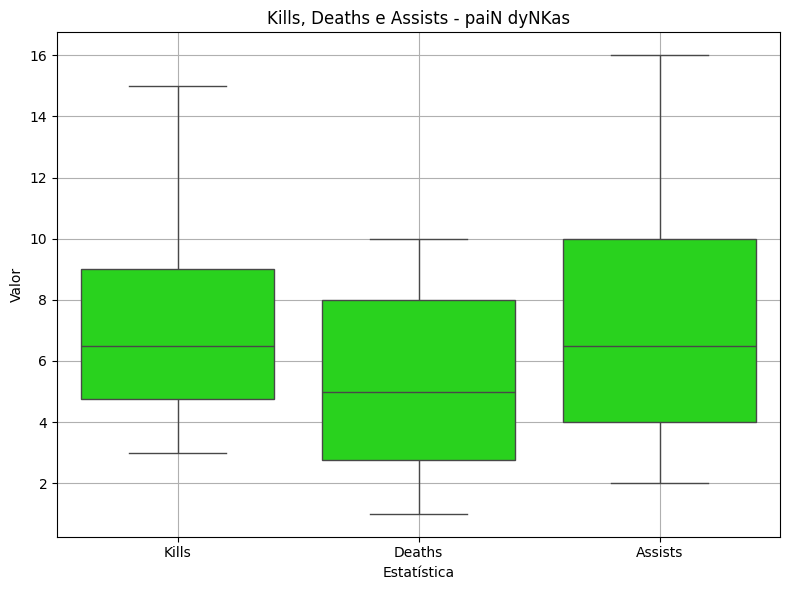

In [ ]:

melted_df = filtered_df[["Kills", "Deaths", "Assists"]].melt(var_name="Estatística", value_name="Valor") #TROCAR AQUI AS VARIÁVEIS "KD", "KDA", "DR" ou
                                                                                          #"Kills", "Deaths", "Assists"
# Criar o boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=melted_df, x="Estatística", y="Valor", color="#0ff000")
plt.title(f"Kills, Deaths e Assists - {summonerName}") #TROCAR AQUI AS VARIÁVEIS     KD, KDA e DR    ou    Kills, Deaths e Assists
plt.grid(True)
plt.tight_layout()
plt.show()

1.2. Grafico DF

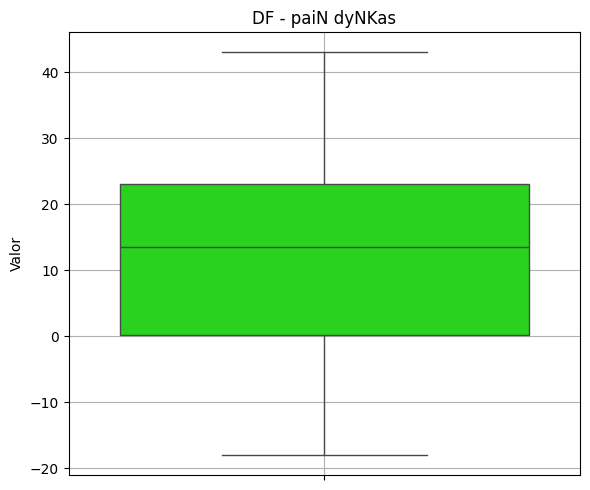

In [ ]:
stat = "DF"  # Métrica única que você quer analisar

# Criar o boxplot para apenas uma estatística
plt.figure(figsize=(6, 5))
sns.boxplot(data=filtered_df, y=stat, color="#0ff000")  # Cor personalizada

plt.title(f"{stat} - {summonerName}")
plt.ylabel("Valor")
plt.grid(True)
plt.tight_layout()
plt.show()

2. HISTOGRAMA

2.1. Varios graficos de uma vez

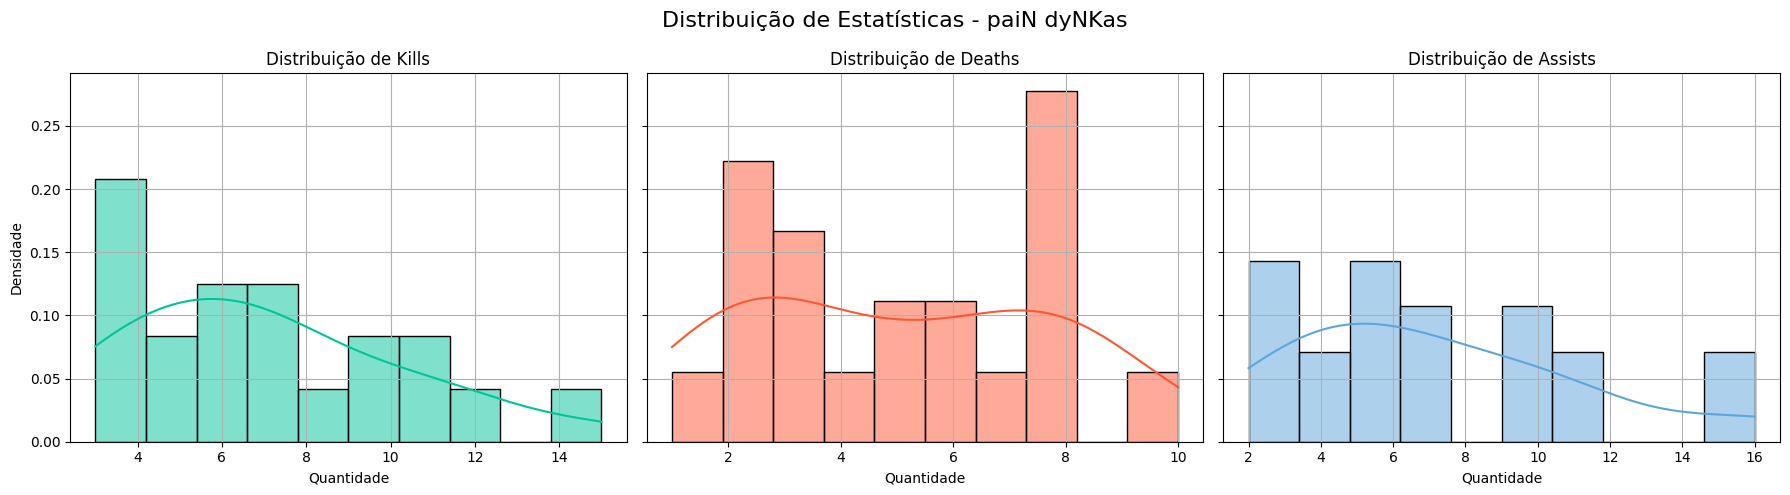

In [ ]:
# Criar subplots para as variáveis separadamente
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Cores personalizadas

cores = {
    "Kills": "#00C49A",     # Verde água escuro
    "Deaths": "#FF5733",    # Laranja avermelhado
    "Assists": "#5DA5DA"    # Azul claro
}

# Criar histogramas separados para cada métrica
for ax, stat in zip(axes, ["Kills", "Deaths", "Assists"]):  #TROCAR AQUI AS VARIÁVEIS "KD", "KDA", "DR" ou
    sns.histplot(                               #"Kills", "Deaths", "Assists"
        data=filtered_df,
        x=stat,
        bins=10,
        kde=True,
        stat="density",
        color=cores[stat],
        ax=ax
    )
    ax.set_title(f"Distribuição de {stat}")
    ax.set_xlabel("Quantidade")
    ax.set_ylabel("Densidade")
    ax.grid(True)

# Título geral do gráfico
plt.suptitle(f"Distribuição de Estatísticas - {summonerName}", fontsize=16)
plt.tight_layout()
plt.show()


2.2. GRÁFICO DF

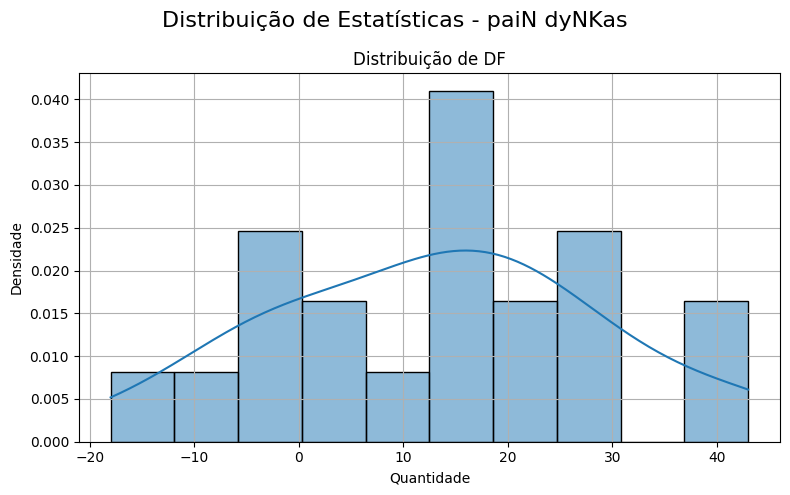

In [ ]:
# Estatística que você quer plotar (escolha uma das que você usaria antes)
stat = "DF"

# Criar histograma para uma única métrica
plt.figure(figsize=(8, 5))
sns.histplot(
    data=filtered_df,
    x=stat,
    bins=10,
    kde=True,
    stat="density",
)

plt.title(f"Distribuição de {stat}")
plt.xlabel("Quantidade")
plt.ylabel("Densidade")
plt.grid(True)

# Título geral (pode remover se for só um gráfico mesmo)
plt.suptitle(f"Distribuição de Estatísticas - {summonerName}", fontsize=16)
plt.tight_layout()
plt.show()


MATRIZES DE CORRELAÇÃO

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Databases/win_lose_filtered.csv")
player_filter = ["roboca de sacola", "tinowns01", "pain dynkas", "titan"]

# Filtrar os nomes ignorando espaços e caixa alta
df_filtrado = df[df["Summoner Name"].str.strip().str.lower().isin(player_filter)]
colunas_analise = ["Kills", "Deaths", "Assists", "KD", "KDA", "DF", "DR","Team FK","Team Win"]
correlacao = df_filtrado[colunas_analise].corr()


In [ ]:
#VISUALIZAÇÃO COM HEATMAP

plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação - 4 Jogadores")
plt.show()


TODOS OS PLAYERS

In [ ]:
df_all = df
colunas_analise = ["Kills", "Deaths", "Assists", "KD", "KDA", "DF", "DR","Team FK","Team Win"]
correlacao_all = df_all[colunas_analise].corr()

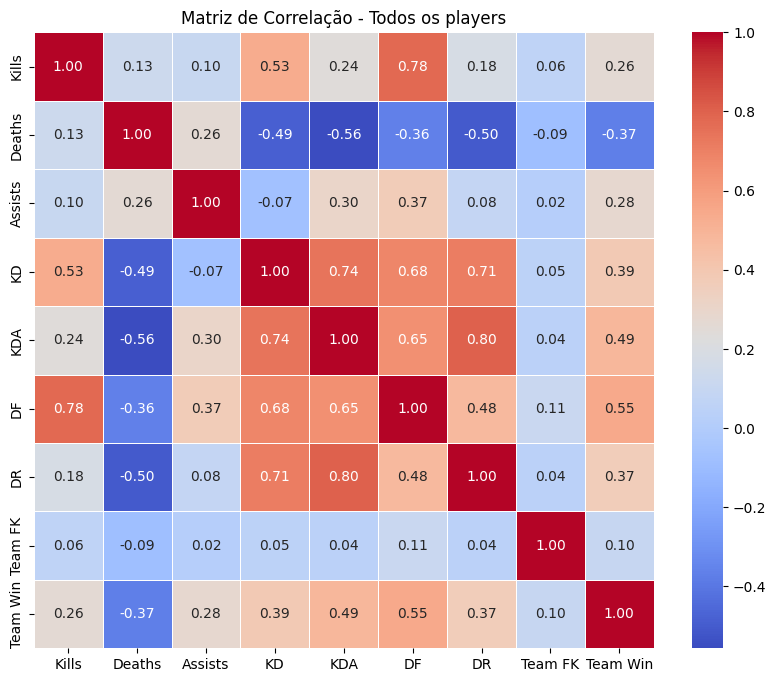

In [ ]:
#VISUALIZAÇÃO COM HEATMAP

plt.figure(figsize=(10, 8))
sns.heatmap(correlacao_all, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação - Todos os players")
plt.show()

# MACHINE LEARNING - RANDOM FOREST

## REGRESSION

LIMPANDO OUTLIERS

In [ ]:
# 1. Carregar os datasets
df_principal = pd.read_csv("/content/drive/MyDrive/Databases/win_lose_filtered.csv")   # Seu banco de dados completo
df_outliers = pd.read_csv("/content/drive/MyDrive/Databases/Outliers.csv")       # Seu arquivo só com os outliers


# Juntar "Game ID" + "Summoner Name" em uma única chave para facilitar a comparação
df_principal["chave"] = df_principal["Game ID"].astype(str) + "-" + df_principal["Summoner Name"].str.strip()
df_outliers["chave"] = df_outliers["Game ID"].astype(str) + "-" + df_outliers["Summoner Name"].str.strip()

# Agora manter apenas as linhas que NÃO estão na lista de outliers
df_sem_outliers = df_principal[~df_principal["chave"].isin(df_outliers["chave"])]

# Remover a coluna auxiliar 'chave'
df_sem_outliers = df_sem_outliers.drop(columns=["chave"])
df_sem_outliers = df_sem_outliers.reset_index(drop=True)

# Visualizar o resultado
print(df_sem_outliers)



In [ ]:
# Carregar o arquivo
#df = pd.read_csv("/content/drive/MyDrive/Databases/win_lose_filtered.csv") #COM OUTLIERS
df = df_sem_outliers #SEM OUTLIERS

# Definir a lista de variáveis de interesse
variaveis = ["Kills", "Deaths", "Assists", "KD", "KDA", "DF", "DR"]

# Preparar a função para rodar regressão para cada variável
resultados = []

for alvo in variaveis:
    # Definir y como a variável alvo
    y = df[alvo]

    # Definir X como todas as outras variáveis, exceto o alvo
    X = df[[v for v in variaveis if v != alvo]]

    # Criar o modelo
    modelo = RandomForestRegressor(random_state=42)

    # Definir o KFold (5 partes)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    mae_scores = []
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        mae_scores.append(mean_absolute_error(y_test, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # Guardar os resultados
    resultados.append({
        "Variável": alvo,
        "MAE Médio": np.mean(mae_scores),
        "RMSE Médio": np.mean(rmse_scores)
    })

# Criar DataFrame de resultados
df_resultados = pd.DataFrame(resultados)

# Visualizar
print(df_resultados)


## CLASSIFIER

In [ ]:
# Carregar o dataset
#df = pd.read_csv("/content/drive/MyDrive/Databases/win_lose_filtered.csv")
df = df_sem_outliers #SEM OUTLIERS

# Definir variáveis
X = df[["Kills", "Deaths", "Assists", "KD", "KDA", "DF", "DR"]]  # Atributos de entrada
y = df["Team Win"]  # Variável de saída (0 ou 1)

# 4. Criar o modelo
modelo = RandomForestClassifier(random_state=42)

# Definir KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar via cross-validation
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Mostrar resultados médios
print(f"Acurácia média: {np.mean(accuracy_scores):.4f}")
print(f"Precision média: {np.mean(precision_scores):.4f}")
print(f"Recall média: {np.mean(recall_scores):.4f}")
print(f"F1-Score média: {np.mean(f1_scores):.4f}")


# XGBoost

## REGRESSOR


In [ ]:
# Carregar o dataset
df = pd.read_csv("/content/drive/MyDrive/Databases/win_lose_filtered.csv")
#df = df_sem_outliers #SEM OUTLIERS

y = df["Assists"]  # variável alvo
X = df[["Kills", "Deaths", "KD", "KDA", "DF", "DR"]]  # entrada (sem 'Kills')

# Definir modelo
modelo = XGBRegressor(random_state=42)

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Resultados finais
print(f"MAE médio: {np.mean(mae_scores):.4f}")
print(f"RMSE médio: {np.mean(rmse_scores):.4f}")

MAE médio: 0.9452
RMSE médio: 1.7234


## CLASSIFIER


In [ ]:
# Carregar o dataset
df = pd.read_csv("/content/drive/MyDrive/Databases/win_lose_filtered.csv")
#df = df_sem_outliers #SEM OUTLIERS

# Definir X e y
X = df[["Kills", "Deaths", "Assists", "KD", "KDA", "DF", "DR"]]
y = df["Team Win"]

# Criar o modelo
modelo = XGBClassifier(random_state=42, eval_metric='logloss')

# Validar com K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Resultados finais
resultados = {
    "Métrica": ["Acurácia", "Precision", "Recall", "F1-Score"],
    "Valor Médio": [
        np.mean(accuracy_scores),
        np.mean(precision_scores),
        np.mean(recall_scores),
        np.mean(f1_scores)
    ]
}

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

     Métrica  Valor Médio
0   Acurácia     0.731250
1  Precision     0.723839
2     Recall     0.737528
3   F1-Score     0.729941


# SVR

In [ ]:
# Carregar o dataset
df = pd.read_csv("/content/drive/MyDrive/Databases/win_lose_filtered.csv")

# Variáveis de entrada por alvo
entradas_por_alvo = {
    "Kills": ["Deaths", "Assists", "KD", "KDA", "DF", "DR"],
    "Deaths": ["Kills", "Assists", "KD", "KDA", "DF", "DR"],
    "Assists": ["Kills", "Deaths", "KD", "KDA", "DF", "DR"]
}

# Guardar resultados
resultados = []

for alvo in ["Kills", "Deaths", "Assists"]:
    X = df[entradas_por_alvo[alvo]]
    y = df[alvo]

    # Normalizar
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    # K-Fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []
    rmse_scores = []

    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]

        modelo = SVR()
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Desnormalizar
        y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

        mae_scores.append(mean_absolute_error(y_test_inv, y_pred_inv))
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        rmse_scores.append(rmse)

    resultados.append({
        "Variável": alvo,
        "MAE Médio": np.mean(mae_scores),
        "RMSE Médio": np.mean(rmse_scores)
    })

# Mostrar resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

  Variável  MAE Médio  RMSE Médio
0    Kills   0.303156    0.685157
1   Deaths   0.242815    0.523741
2  Assists   0.515532    1.216637


# SVG

In [ ]:
from sklearn.svm import SVC

# Carregar o dataset
df = pd.read_csv("/content/drive/MyDrive/Databases/win_lose_filtered.csv")

# Definir X e y
X = df[["Kills", "Deaths", "Assists", "KD", "KDA", "DF", "DR"]]
y = df["Team Win"]

# Normalizar X (SVM precisa de dados escalados)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Inicializar o modelo SVM
modelo = SVC(kernel="rbf", random_state=42)

# K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Rodar validação cruzada
for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Exibir resultados como tabela
df_resultados = pd.DataFrame({
    "Métrica": ["Acurácia", "Precision", "Recall", "F1-Score"],
    "Valor Médio": [
        np.mean(accuracy_scores),
        np.mean(precision_scores),
        np.mean(recall_scores),
        np.mean(f1_scores)
    ]
})
print(df_resultados)

     Métrica  Valor Médio
0   Acurácia     0.783750
1  Precision     0.766894
2     Recall     0.807775
3   F1-Score     0.786474
